# Transient ERF

In [ ]:
# From the RFMIP paper:
# "Transient ERFs will be computed by differencing top-of-atmosphere energy diagnostics
# from three ensemble members employing time varying forcing-agent changes with the energy budget diagnostics
# from the 30-year control simulation. These integrations will
# use the same prescribed preindustrial climatology of SST
# and sea ice as in the time-slice ERF experiments. "

# From Forster et al. (2016):
# "Conceptually, the ERF that is most representative of a model's 
# response would come from applying the time-varying SSTs
# and sea ice from the equivalently forced coupled model run in the ERF calculation. 
# This is the ERF_trans method proposed by AerChemMIP [Collins et al., 2016]."

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
import xarray as xr
from estimation import *
#import importlib
#import my_functions as f
#importlib.reload(f) # needed to load new changes in my_functions

In [2]:
# print out models and members where I have piClim-histall and piClim-control data:
experiments = {}
directory = '../Processed_data/Global_annual_means/'
model_names = [ f.name for f in os.scandir(directory) if f.is_dir() and f.name !='.ipynb_checkpoints']

for model in model_names:
    modeldirectory = os.path.join(directory, model)
    modelexp_names = [ f.name for f in os.scandir(modeldirectory) if f.is_dir() and f.name !='.ipynb_checkpoints']

    if 'piClim-histall' in modelexp_names and 'piClim-control' in modelexp_names:
        experiments[model] = {}
        for exp in ['piClim-histall', 'piClim-control']:
            experiments[model][exp] = find_members(model, exp, datatype = 'means')
    
experiments

{'NorESM2-LM': {'piClim-histall': ['r1i1p1f1',
   'r1i1p2f1',
   'r2i1p1f1',
   'r2i1p2f1',
   'r3i1p1f1',
   'r3i1p2f1'],
  'piClim-control': ['r1i1p1f1', 'r1i1p2f1']},
 'HadGEM3-GC31-LL': {'piClim-histall': ['r1i1p1f3', 'r2i1p1f3', 'r3i1p1f3'],
  'piClim-control': ['r1i1p1f3']},
 'GISS-E2-1-G': {'piClim-histall': ['r1i1p1f1', 'r1i1p1f2', 'r1i1p3f2'],
  'piClim-control': ['r1i1p1f1', 'r1i1p1f2', 'r1i1p3f1', 'r1i1p3f2']},
 'CNRM-CM6-1': {'piClim-histall': ['r1i1p1f2'],
  'piClim-control': ['r1i1p1f2']},
 'EC-Earth3': {'piClim-histall': ['r2i1p1f1'],
  'piClim-control': ['r1i1p1f1', 'r2i1p1f1']},
 'IPSL-CM6A-LR': {'piClim-histall': ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1'],
  'piClim-control': ['r1i1p1f1',
   'r2i1p1f1',
   'r3i1p1f1',
   'r4i1p1f1',
   'r5i1p1f1']},
 'MIROC6': {'piClim-histall': ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1'],
  'piClim-control': ['r11i1p1f1', 'r1i1p1f1']},
 'GFDL-CM4': {'piClim-histall': ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1'],
  'piClim-control': ['r1i1p1f1']},
 'CanES

## Compute ERF for one model

In [35]:
# choose model and load data

model =  'GFDL-CM4'; 
control_member = 'r1i1p1f1'
piControl_member = 'r1i1p1f1'
histall_member = 'r1i1p1f1'

# load files:
piclimcontrol_path = '../Processed_data/Global_annual_means/' + model + '/piClim-control/'
histall_path = '../Processed_data/Global_annual_means/' + model + '/piClim-histall/'
#histcoupled_path = '../Processed_data/Global_annual_means/' + model + '/historical/'
piControlcoupled_path = '../Processed_data/Global_annual_means/' + model + '/piControl/'

histall_filename = model + '_piClim-histall_' + histall_member + '_means.csv'
exp_data = pd.read_csv(histall_path + histall_filename, index_col=0)

#histcoupled_filename = model + '_historical_' + member + '_means.csv'
#historical_data = pd.read_csv(histcoupled_path + histcoupled_filename, index_col=0)

piControlcoupled_filename = model + '_piControl_' + piControl_member + '_means.csv'
piControl_data = pd.read_csv(piControlcoupled_path + piControlcoupled_filename, index_col=0)

piclim_control_filename = model + '_piClim-control_' + control_member + '_means.csv'
control_data = pd.read_csv(piclimcontrol_path + piclim_control_filename, index_col=0)


In [36]:
hist_tas = exp_data['tas']
#histcoupled_tas = historical_data['tas']
control_tas = control_data['tas']
piControl_tas = piControl_data['tas']

histN = exp_data['rsdt'] - exp_data['rsut'] - exp_data['rlut']
#histcoupledN = historical_data['rsdt'] - historical_data['rsut'] - historical_data['rlut']
controlN = control_data['rsdt'] - control_data['rsut'] - control_data['rlut']
piControlN = piControl_data['rsdt'] - piControl_data['rsut'] - piControl_data['rlut']


Temperature difference for the last 20 years is on average 0.30255309519895945 K


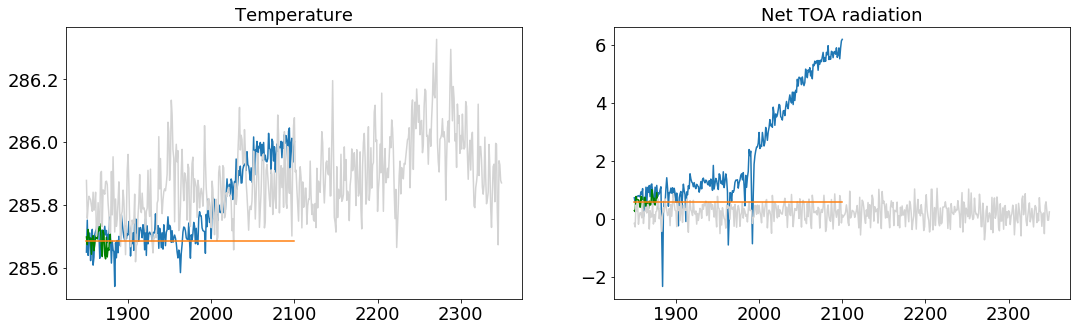

In [37]:
fig, ax = plt.subplots(figsize = [18,5], ncols = 2)
years = np.arange(1850, 1850+len(hist_tas))
piclimyears = years[:len(control_tas)]

ax[0].plot(years, hist_tas)
ax[0].plot(piclimyears, control_tas, color = 'green')
ax[0].plot(np.arange(1850, 1850+len(piControl_tas)), piControl_tas, color = 'lightgray')
ax[0].plot(years,[control_tas.mean()]*len(hist_tas))
ax[0].set_title('Temperature',fontsize = 18)
print('Temperature difference for the last 20 years is on average', np.mean(hist_tas[-20:]) - control_tas.mean(), 'K')

ax[1].plot(years,histN)
ax[1].plot(piclimyears, controlN, color = 'green')
ax[1].plot(np.arange(1850, 1850+len(piControlN)), piControlN, color = 'lightgray')
ax[1].plot(years,[controlN.mean()]*len(histN))
ax[1].set_title('Net TOA radiation',fontsize = 18)

for axes in ax:
    axes.tick_params(axis='both',labelsize=18)  
    #axes.set_xlim(1850, 2100)

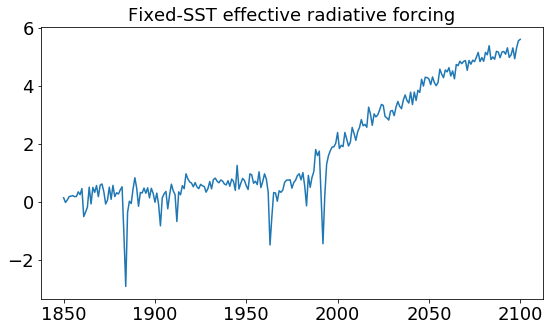

In [38]:
fig, ax = plt.subplots(figsize = [9,5])
effradf = histN - controlN.mean()
ax.plot(years,effradf);
ax.tick_params(axis='both',labelsize=18)  
ax.set_title('Fixed-SST effective radiative forcing',fontsize = 18);


## Compute forcing for MPI-ESM1-2-LR using data from Angshuman (in netcdf format)

In [66]:
# choose model and load data

model =  'MPI-ESM1-2-LR'; 
variables = ['tas', 'rlut', 'rsut', 'rsdt']
modelpath = '../Processed_data/Global_annual_means/MPI-ESM1-2-LR/fixedSST_from_Angshuman'

# load files:
piclimcontrol_path = modelpath + '/piClim-control/'
histall_path = modelpath + '/piClim-histall/'
piControlcoupled_path = '../Processed_data/Global_annual_means/MPI-ESM1-2-LR/piControl/'

exp_data = pd.DataFrame(columns = variables, index = np.arange(1851, 2014+1))
control_data = pd.DataFrame(columns = variables, index = np.arange(1850, 1899+1))
control_data.index.name = 'year'
exp_data.index.name = 'year'

for var in variables:
    exp_var_data = xr.open_dataset(histall_path + var + '_hist_forcing_piSST_MPI-ESM1.2-LR_1851_2014.nc')
    exp_data[var] = np.array(exp_var_data[var].values.flat)
    if var == 'tas':
        control_var = 'temp2'
    else:
        control_var = var
    control_var_data = xr.open_dataset(piclimcontrol_path + control_var + '_mpiesm1-2-LR_ctl-fsst_1850_1899.nc')
    control_data[var] = np.abs(control_var_data[control_var].values.flat)
    # abs defines all values to be positive
    
piControl_member = 'r1i1p1f1'
piControlcoupled_filename = model + '_piControl_' + piControl_member + '_means.csv'
piControl_data = pd.read_csv(piControlcoupled_path + piControlcoupled_filename, index_col=0)


In [68]:
control_data;

In [60]:
exp_data_df;

In [69]:
hist_tas = exp_data['tas']
#histcoupled_tas = historical_data['tas']
control_tas = control_data['tas']
piControl_tas = piControl_data['tas']

histN = exp_data['rsdt'] - exp_data['rsut'] - exp_data['rlut']
#histcoupledN = historical_data['rsdt'] - historical_data['rsut'] - historical_data['rlut']
controlN = control_data['rsdt'] - control_data['rsut'] - control_data['rlut']
piControlN = piControl_data['rsdt'] - piControl_data['rsut'] - piControl_data['rlut']


Temperature difference for the last 20 years is on average 0.12130737 K


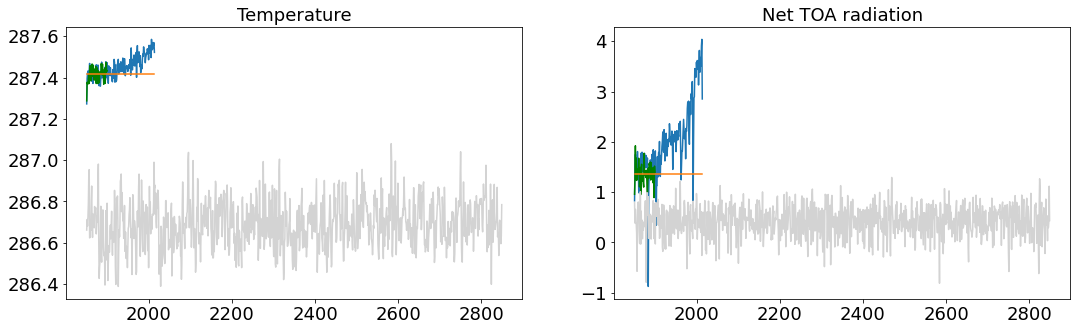

In [70]:
fig, ax = plt.subplots(figsize = [18,5], ncols = 2)
years = np.arange(1850, 1850+len(hist_tas))
piclimyears = years[:len(control_tas)]

ax[0].plot(years, hist_tas)
ax[0].plot(piclimyears, control_tas, color = 'green')
ax[0].plot(np.arange(1850, 1850+len(piControl_tas)), piControl_tas, color = 'lightgray')
ax[0].plot(years,[control_tas.mean()]*len(hist_tas))
ax[0].set_title('Temperature',fontsize = 18)
print('Temperature difference for the last 20 years is on average', np.mean(hist_tas[-20:]) - control_tas.mean(), 'K')

ax[1].plot(years,histN)
ax[1].plot(piclimyears, controlN, color = 'green')
ax[1].plot(np.arange(1850, 1850+len(piControlN)), piControlN, color = 'lightgray')
ax[1].plot(years,[controlN.mean()]*len(histN))
ax[1].set_title('Net TOA radiation',fontsize = 18)

for axes in ax:
    axes.tick_params(axis='both',labelsize=18)  
    #axes.set_xlim(1850, 2100)

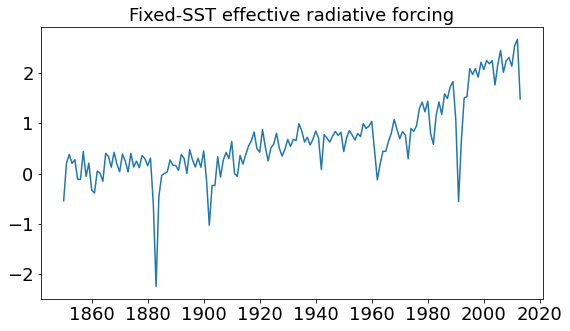

In [73]:
fig, ax = plt.subplots(figsize = [9,5])
effradf = histN - controlN.mean()
ax.plot(years,effradf);
ax.tick_params(axis='both',labelsize=18)  
ax.set_title('Fixed-SST effective radiative forcing',fontsize = 18);

# save values for this model:

df_forcing = pd.DataFrame(effradf.values, index=exp_data.index, columns=['ERF'])
# save file
modelfilename = model + '_Angshuman_transientERF.csv'
df_forcing.to_csv('../Estimates/piClim-histall_forcing/' + modelfilename)

# save temperature responses also:
tas_response = hist_tas - control_tas.mean()
df_tasresponse = pd.DataFrame(tas_response.values, index=exp_data.index, columns=['tas'])
tas_filename = model + '_Angshuman_tas_response.csv'
df_tasresponse.to_csv('../Estimates/piClim-histall_tasresponse/' + tas_filename)

## Loop through available models and members

NorESM2-LM
HadGEM3-GC31-LL
GISS-E2-1-G
CNRM-CM6-1
EC-Earth3
IPSL-CM6A-LR
MIROC6
GFDL-CM4


/Users/hege-beatefredriksen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


CanESM5


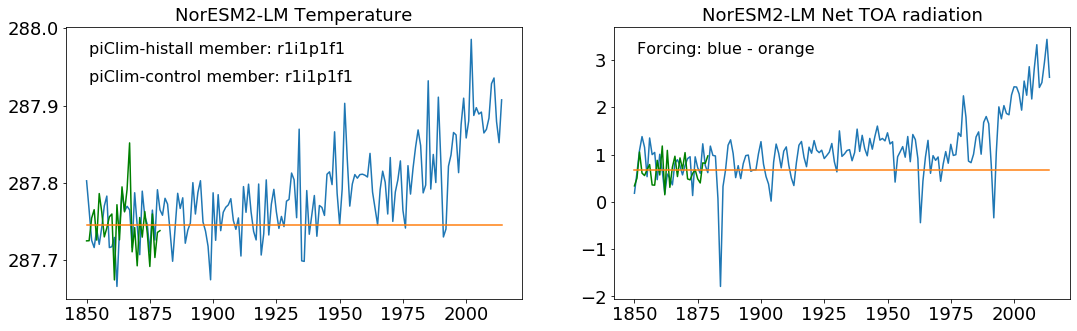

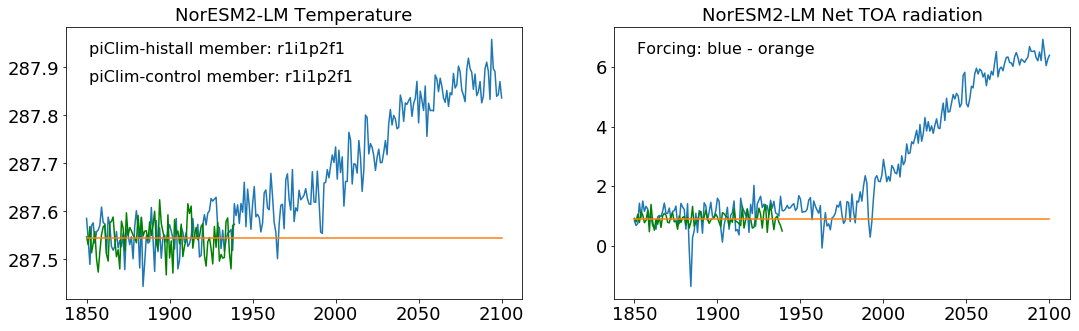

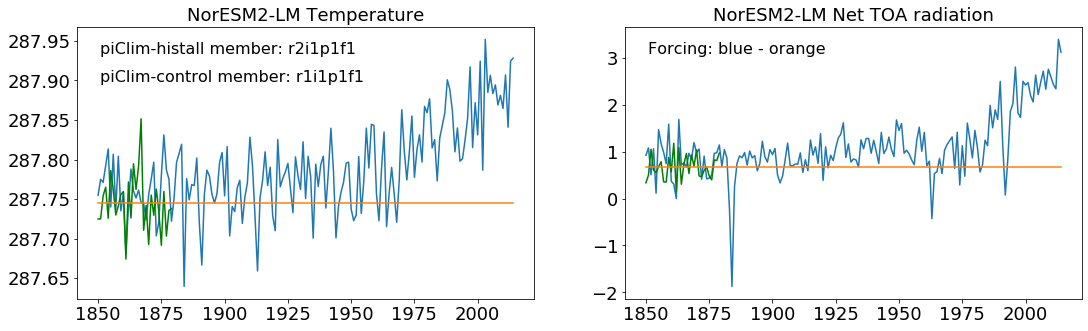

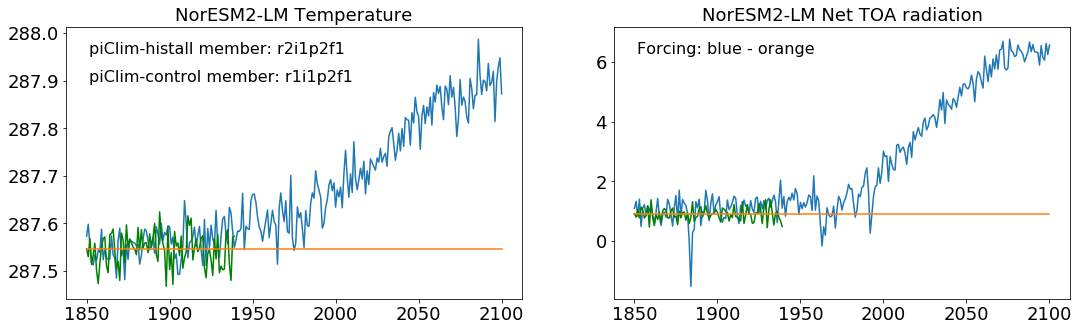

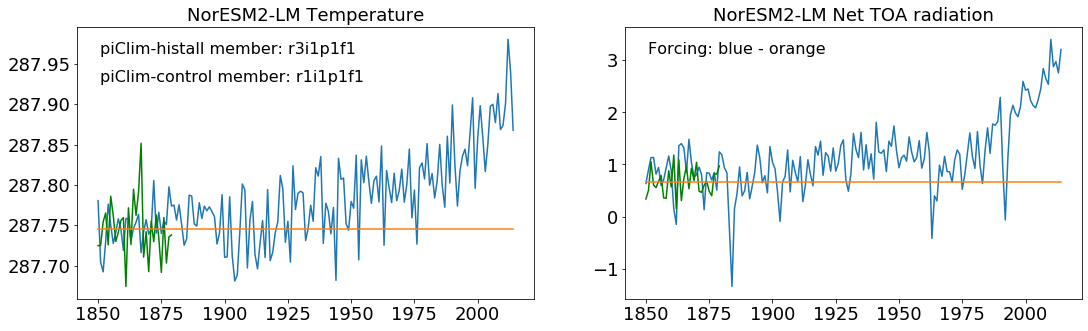

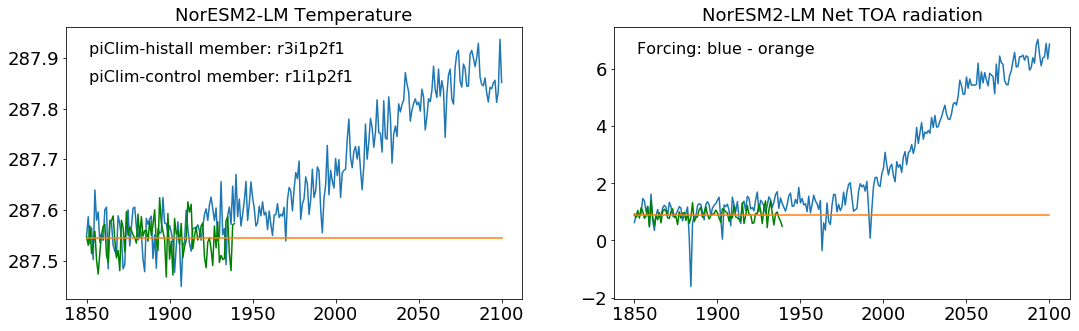

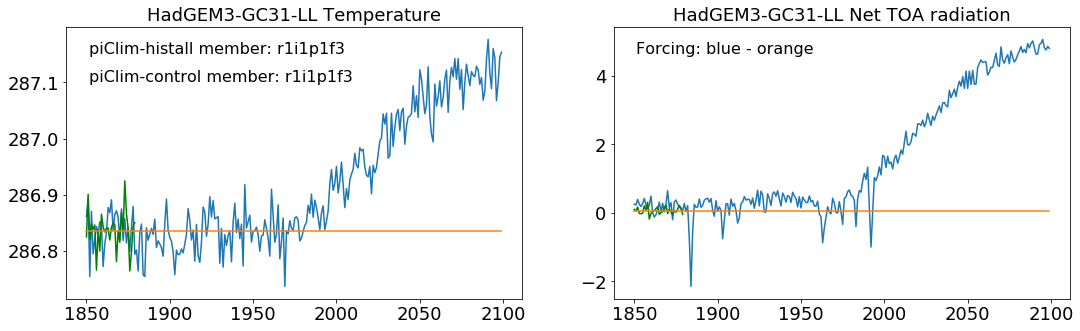

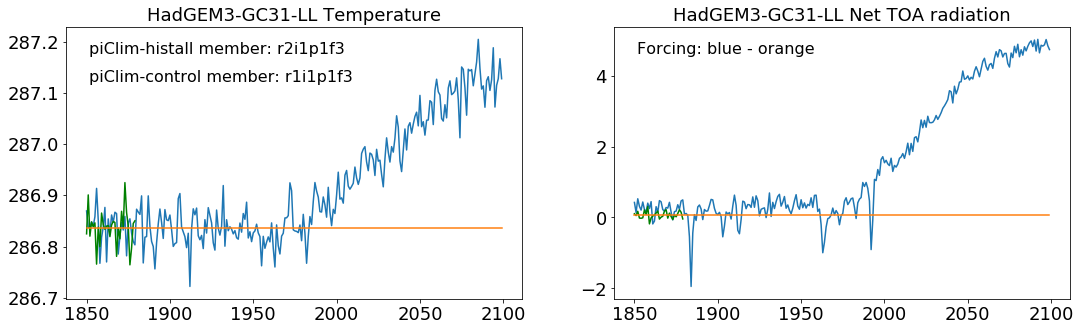

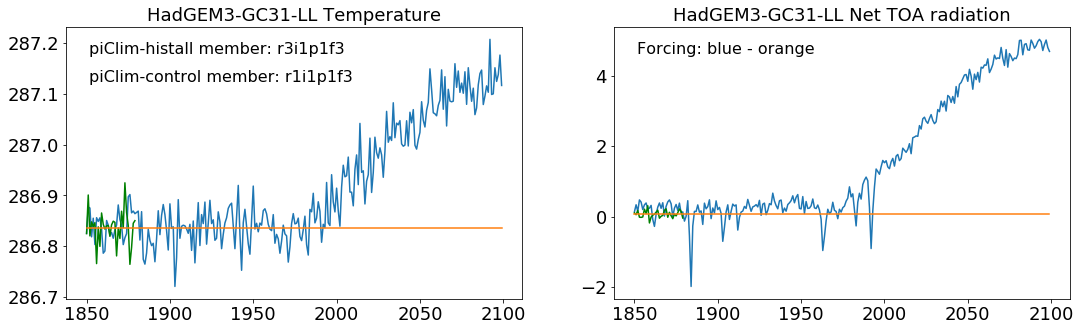

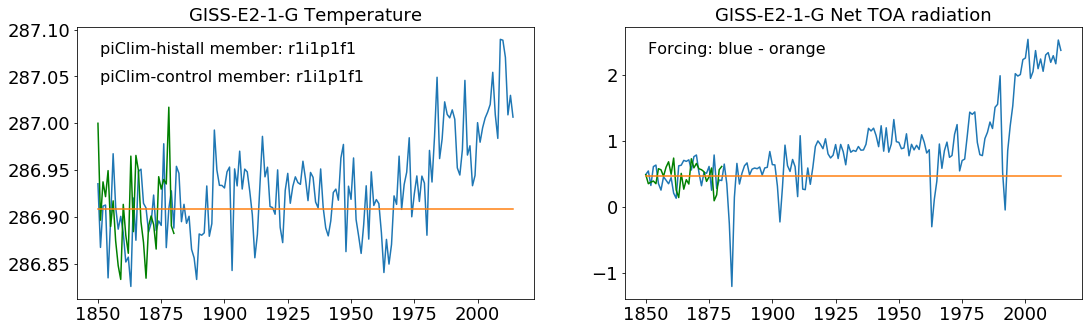

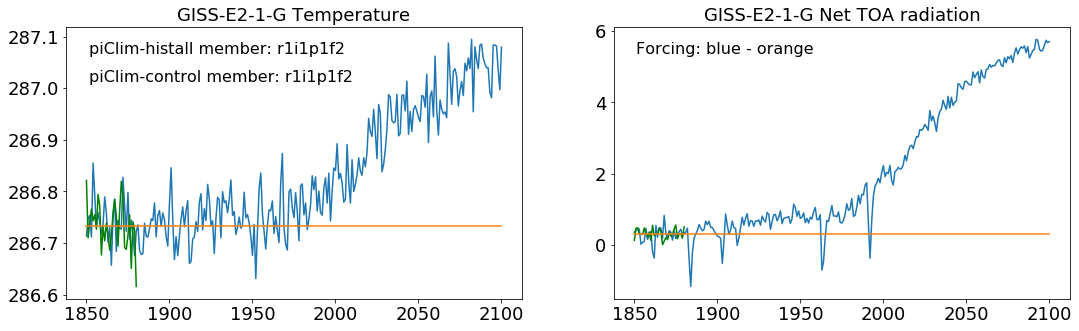

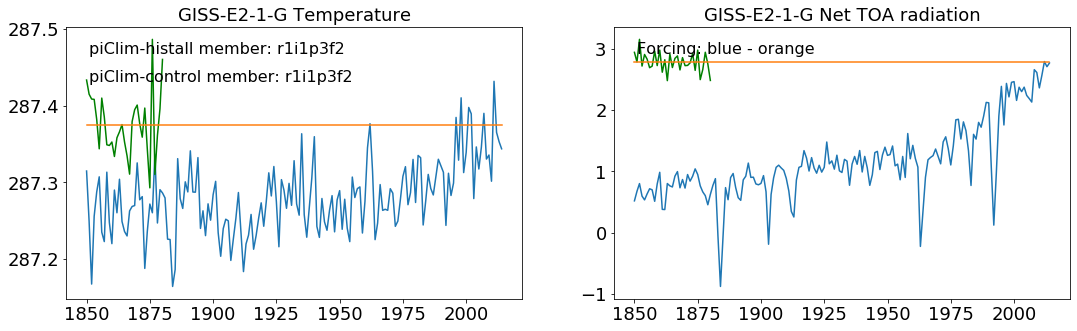

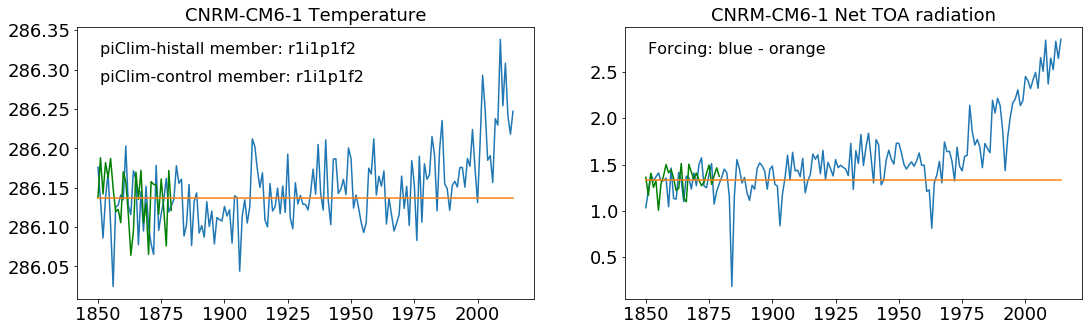

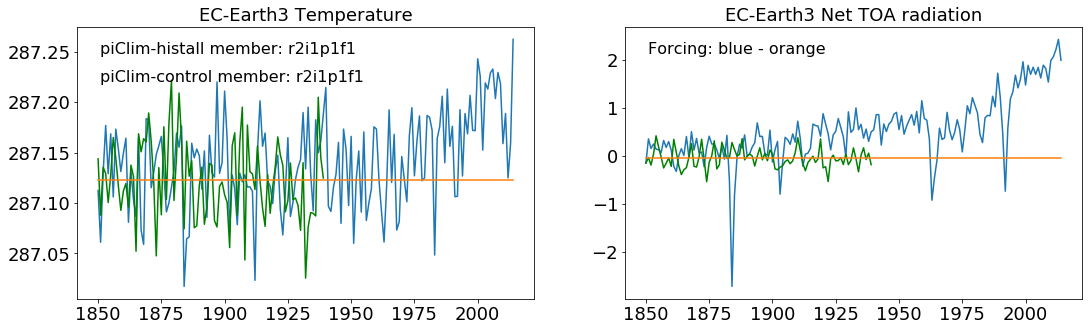

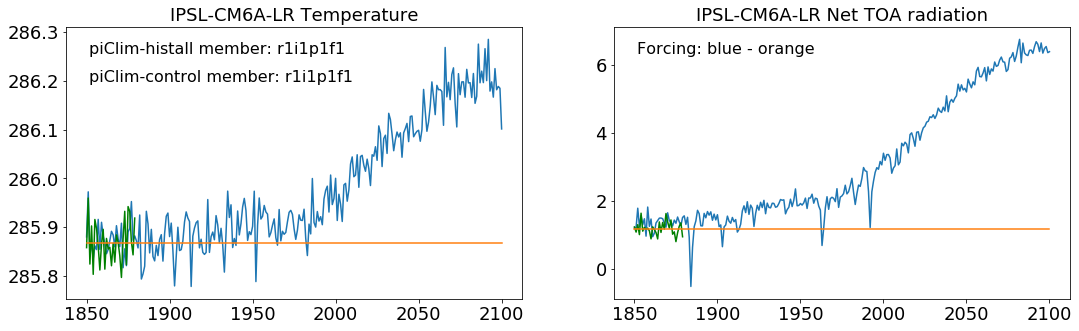

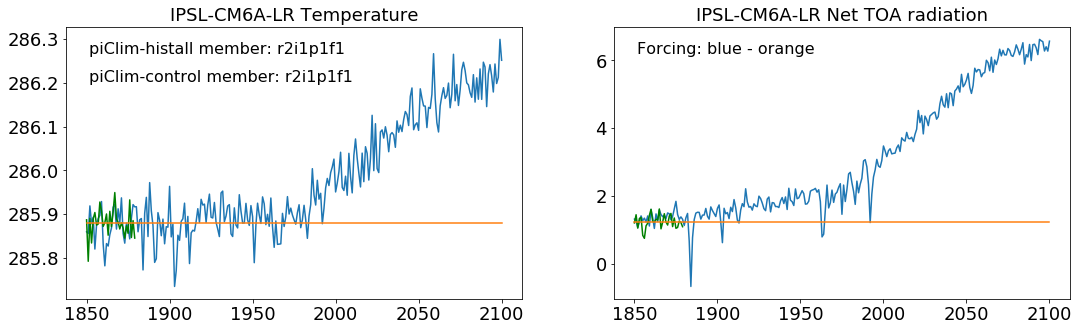

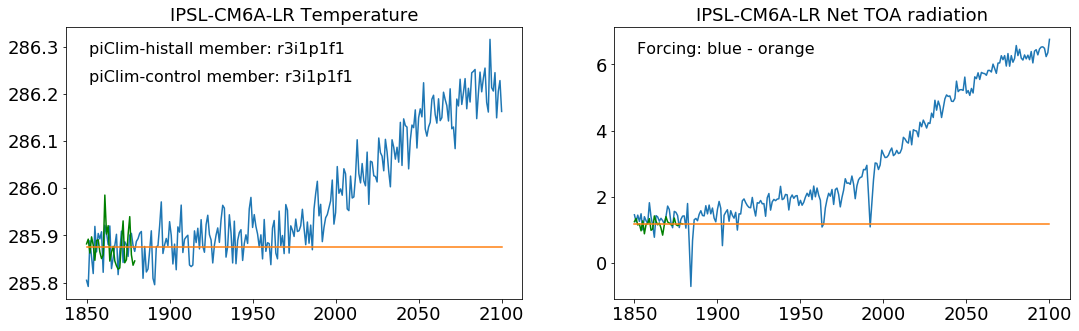

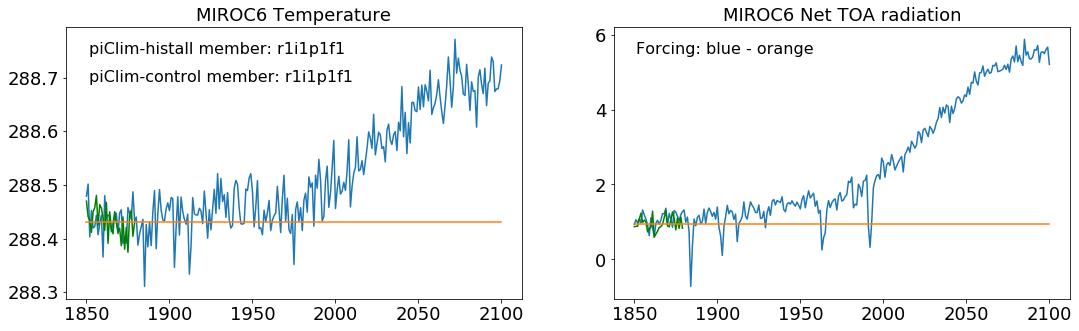

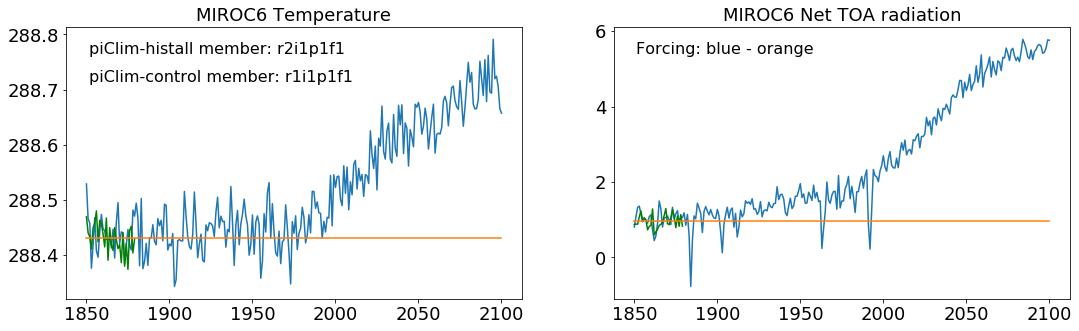

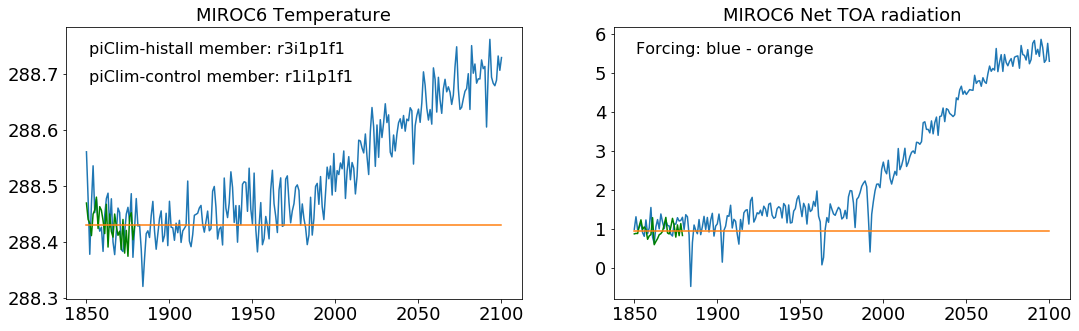

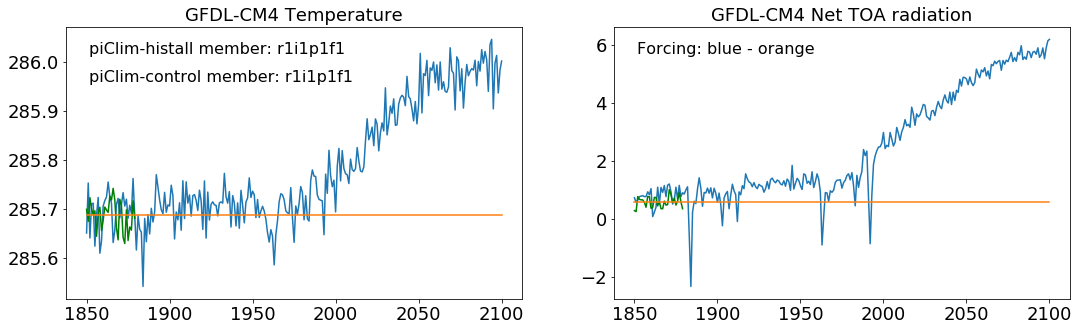

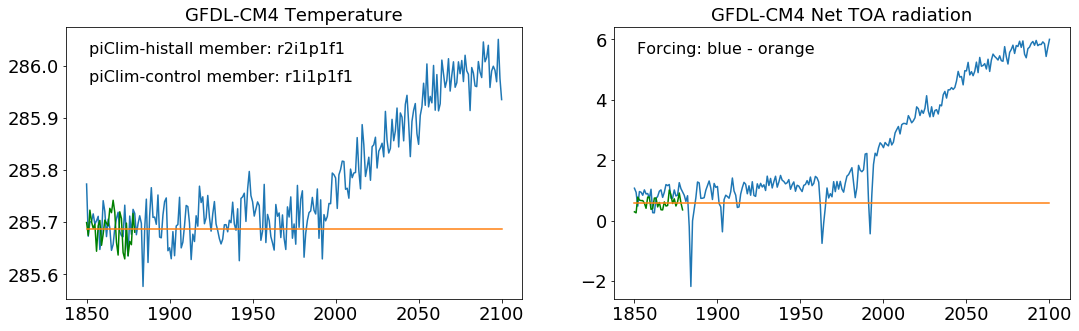

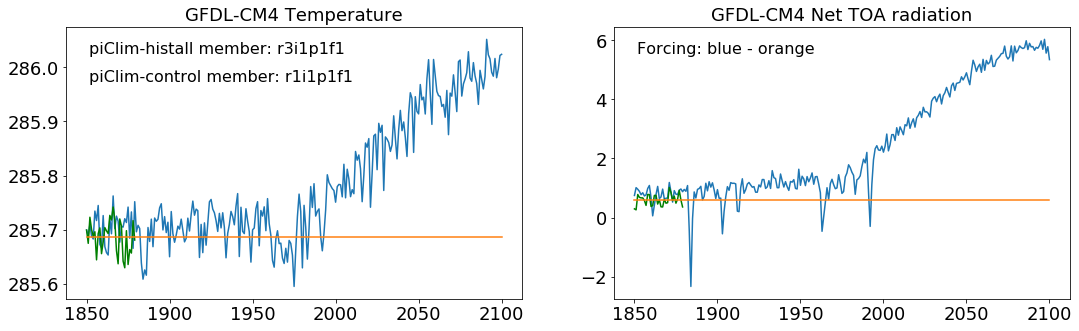

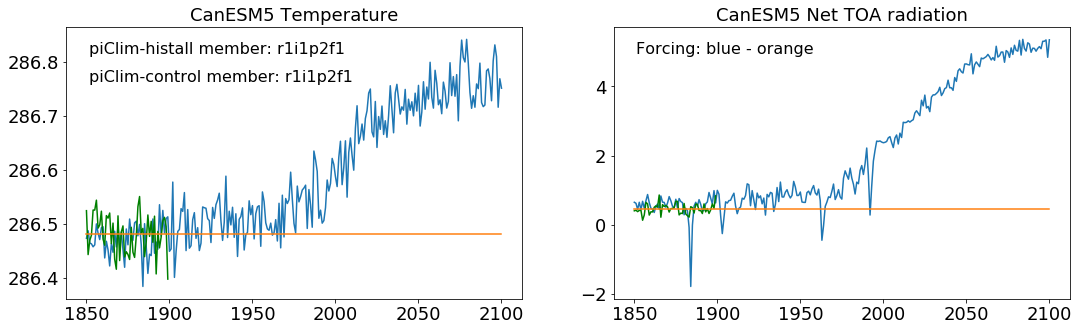

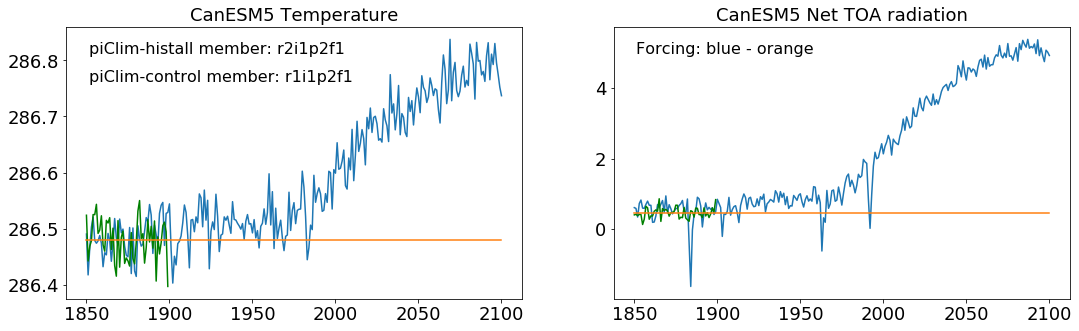

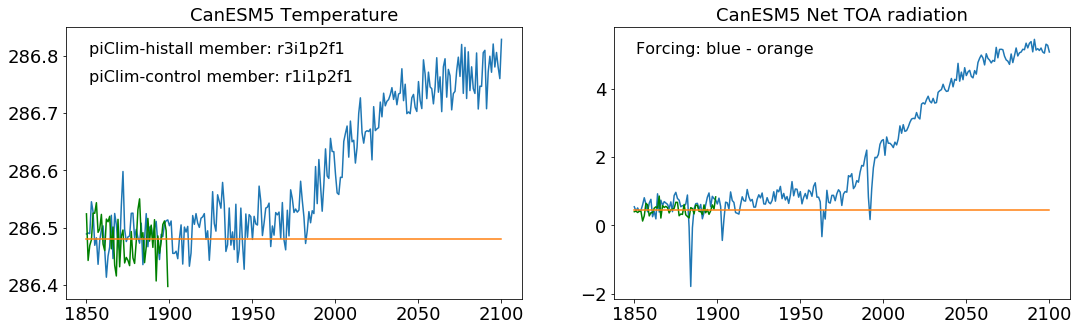

In [10]:
for model in experiments.keys():
    print(model)
    for histall_member in experiments[model]['piClim-histall']:
        if histall_member in experiments[model]['piClim-control']:
            piClimcontrol_member = histall_member
        else:
            piClimcontrol_member = 'r1' +  histall_member[2:]

        # load files:
        piclimcontrol_path = '../Processed_data/Global_annual_means/' + model + '/piClim-control/'
        histall_path = '../Processed_data/Global_annual_means/' + model + '/piClim-histall/'

        histall_filename = model + '_piClim-histall_' + histall_member + '_means.csv'
        exp_data = pd.read_csv(histall_path + histall_filename, index_col=0)

        piclim_control_filename = model + '_piClim-control_' + piClimcontrol_member + '_means.csv'
        control_data = pd.read_csv(piclimcontrol_path + piclim_control_filename, index_col=0)

        hist_tas = exp_data['tas']
        control_tas = control_data['tas']
        tas_response = hist_tas - control_tas.mean()
        histN = exp_data['rsdt'] - exp_data['rsut'] - exp_data['rlut']
        controlN = control_data['rsdt'] - control_data['rsut'] - control_data['rlut']

        fig, ax = plt.subplots(figsize = [18,5], ncols = 2)
        #years = np.arange(1850, 1850+len(hist_tas))
        years = exp_data.index
        piclimyears = years[:len(control_tas)]

        ax[0].plot(years, hist_tas)
        ax[0].plot(piclimyears, control_tas, color = 'green')
        ax[0].plot(years,[control_tas.mean()]*len(hist_tas))
        ax[0].set_title(model + ' Temperature',fontsize = 18)
        ax[0].text(0.05, 0.9,'piClim-histall member: ' + histall_member, transform=ax[0,].transAxes, fontsize=16)
        ax[0].text(0.05, 0.8,'piClim-control member: ' + piClimcontrol_member, transform=ax[0,].transAxes, fontsize=16)
        
        #print('Temperature difference for the last 20 years is on average', np.mean(hist_tas[-20:]) - control_tas.mean(), 'K for model ', model)

        ax[1].plot(years,histN)
        ax[1].plot(piclimyears, controlN, color = 'green')
        ax[1].plot(years,[controlN.mean()]*len(histN))
        ax[1].set_title(model + ' Net TOA radiation',fontsize = 18)
        ax[1].text(0.05, 0.9,'Forcing: blue - orange', transform=ax[1,].transAxes, fontsize=16)

        for axes in ax:
            axes.tick_params(axis='both',labelsize=18)  

        #fig2, ax2 = plt.subplots(figsize = [9,5])
        effradf = histN - controlN.mean()
        #ax2.plot(years,effradf);
        #ax2.tick_params(axis='both',labelsize=18)  
        #ax2.set_title(model + ' Fixed-SST effective radiative forcing',fontsize = 18)

        # write data to file
        #index = pd.Index(years, name='Year')
        df_forcing = pd.DataFrame(effradf.values, index=exp_data.index, columns=['ERF'])
        # save file
        modelfilename = model + '_' + histall_member + '_transientERF.csv'
        df_forcing.to_csv('../Estimates/piClim-histall_forcing/' + modelfilename)

        # save temperature responses also:
        df_tasresponse = pd.DataFrame(tas_response.values, index=exp_data.index, columns=['tas'])
        tas_filename = model + '_' + histall_member + '_tas_response.csv'
        df_tasresponse.to_csv('../Estimates/piClim-histall_tasresponse/' + tas_filename)
            
            

## Plot all estimates together in one figure

(1850, 2100)

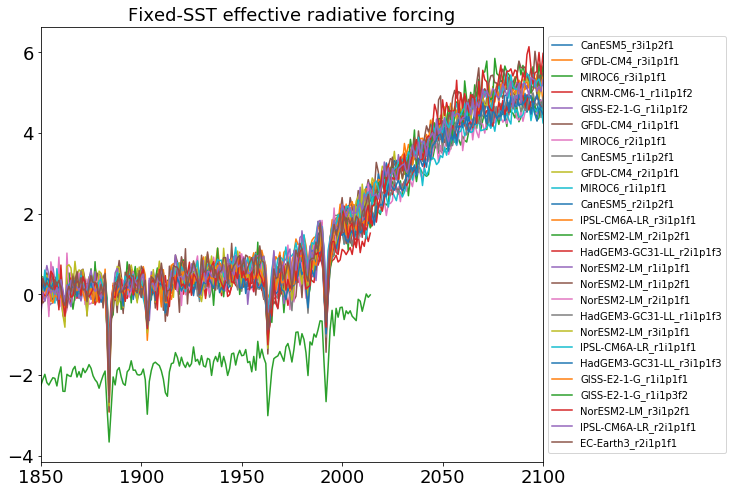

In [14]:
fig, ax = plt.subplots(figsize = [9,8])
ax.tick_params(axis='both',labelsize=18)  
ax.set_title('Fixed-SST effective radiative forcing',fontsize = 18)

directory = '../Estimates/piClim-histall_forcing/'
file_list = [ f.name for f in os.scandir(directory) if f.name !='.ipynb_checkpoints']
for file in file_list:
    data = pd.read_csv(directory + file, index_col=0)
    ax.plot(data['ERF'], label = file[:-17]);
    
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim(1850, 2100)